In [1]:
import pandas as pd
df = pd.read_csv('data/dataset.csv')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [3]:
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [4]:
df

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


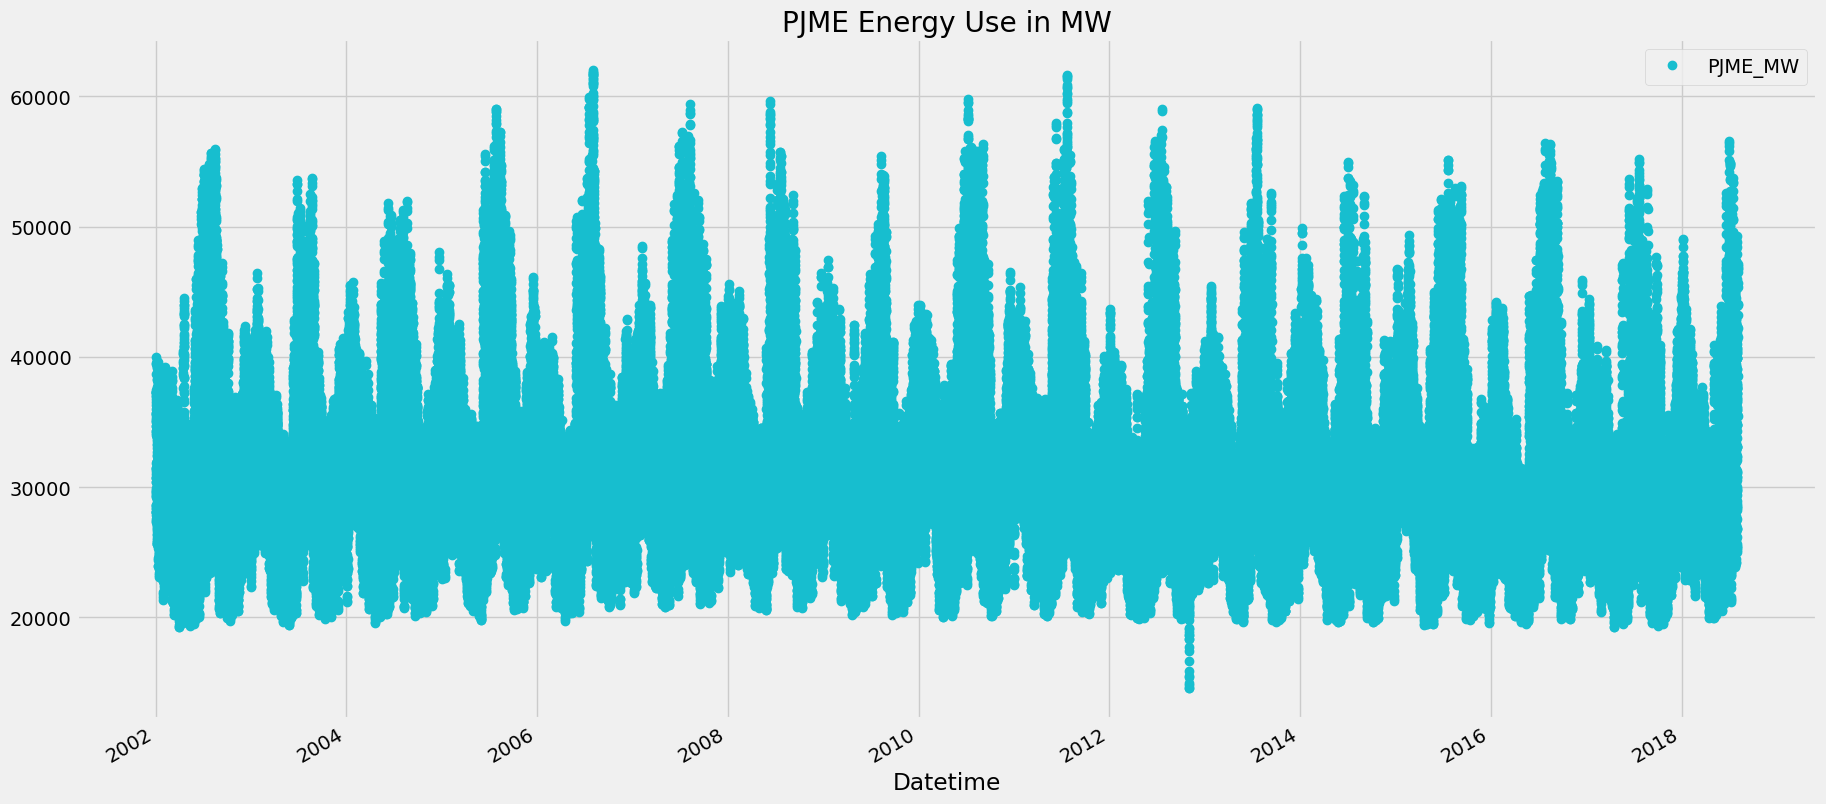

In [5]:
df.plot(style='o',
        figsize=(20, 10),
        color=color_pal[9],
        title='PJME Energy Use in MW')
plt.savefig('my_plot.png')

<Axes: ylabel='Frequency'>

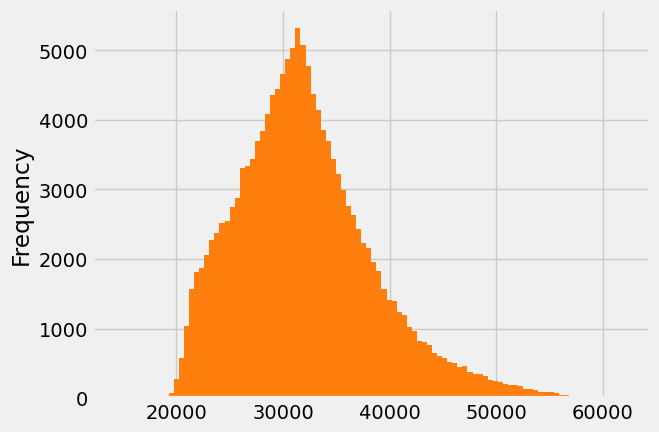

In [6]:
df['PJME_MW'].plot(kind='hist',color=color_pal[1], bins=100)

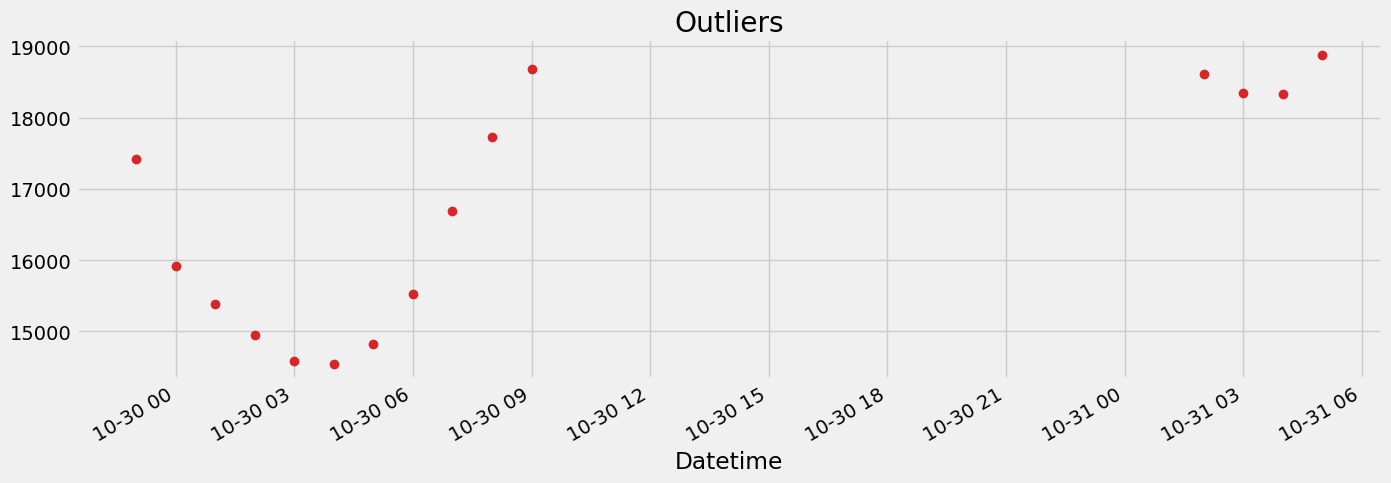

In [7]:
df.query('PJME_MW < 19_000 ')['PJME_MW'] \
    .plot(style='o',
          figsize=(15, 5),
          color=color_pal[3],
          title='Outliers')
plt.savefig('outlier.png')

In [8]:
df = df.query('PJME_MW > 19_000').copy()

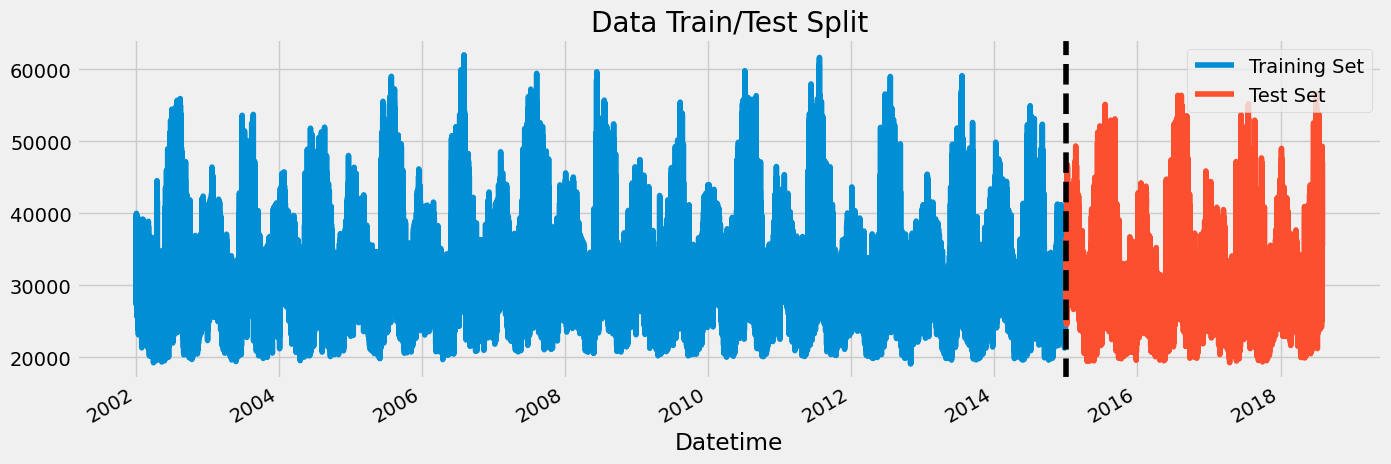

In [9]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [10]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=10, test_size=24*365*1, gap=24)
df = df.sort_index()

In [11]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['date']= df.index.date
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)
df = df.astype({'date':'string'})
df['month_day'] = df['date'].str[5:10]
df = df.astype({'month_day':'string'})

In [12]:
df

,PJME_MW,hour,date,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,month_day
Datetime,,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,2002-01-01,1,1,1,2002,1,1,1,01-01
2002-01-01 02:00:00,29265.0,2,2002-01-01,1,1,1,2002,1,1,1,01-01
2002-01-01 03:00:00,28357.0,3,2002-01-01,1,1,1,2002,1,1,1,01-01
2002-01-01 04:00:00,27899.0,4,2002-01-01,1,1,1,2002,1,1,1,01-01
2002-01-01 05:00:00,28057.0,5,2002-01-01,1,1,1,2002,1,1,1,01-01
...,...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,2018-08-02,3,3,8,2018,214,2,31,08-02
2018-08-02 21:00:00,43256.0,21,2018-08-02,3,3,8,2018,214,2,31,08-02
2018-08-02 22:00:00,41552.0,22,2018-08-02,3,3,8,2018,214,2,31,08-02


In [13]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    df['lag4'] = (df.index - pd.Timedelta('2184 days')).map(target_map)
    return df

In [14]:
# List of specific dates to filter and flag
date_list = [
    "01-01", "02-01", "03-01",
    "06-01", "07-01", "08-01", "01-13", "01-14", "01-16", "01-19", "01-22", "01-29",
    "02-01", "02-02", "02-03", "02-04", "02-06", "02-12", "02-13", "02-14", "02-15", "02-16", "02-18", "02-20", "02-21", "02-22", "02-25", "02-28",
    "03-01", "03-02", "03-03", "03-04", "03-06", "03-07", "03-12", "03-17", "03-20", "03-23", "03-25", "03-26", "03-27", "03-29", "03-30", "03-31",
    "04-02", "04-03", "04-05", "04-06", "04-07", "04-08", "04-09", "04-10", "04-13", "04-14", "04-15", "04-16", "04-17", "04-18", "04-21", "04-22", "04-24", "04-25", "04-26", "04-27", "04-28",
    "05-01", "05-02", "05-04", "05-05", "05-06", "05-08", "05-09", "05-10", "05-12", "05-14", "05-15", "05-18", "05-19", "05-20", "05-22", "05-24", "05-25", "05-26", "05-28", "05-29",
    "06-01", "06-03", "06-04", "06-05", "06-06", "06-08", "06-10", "06-11", "06-12", "06-14", "06-16", "06-17", "06-18", "06-19", "06-20", "06-21", "06-28",
    "07-03", "07-04", "07-13", "07-14", "07-16", "07-19", "07-23", "07-24", "07-27", "07-28",
    "08-01", "08-04", "08-06", "08-07", "08-14", "08-15", "08-16", "08-18", "08-19", "08-20", "08-26", "08-27", "08-30",
    "09-04", "09-06", "09-09", "09-10", "09-11", "09-15", "09-16", "09-17", "09-18", "09-22", "09-23", "09-24", "09-25", "09-28", "09-29", "09-30",
    "10-02", "10-04", "10-06", "10-07", "10-08", "10-09", "10-11", "10-13", "10-14", "10-15", "10-16", "10-18", "10-21", "10-23", "10-27", "10-31",
    "11-01", "11-02", "11-05", "11-07", "11-10", "11-11", "11-12", "11-13", "11-19", "11-23", "11-24", "11-27", "11-28", "11-29",
    "12-01", "12-03", "12-06", "12-07", "12-08", "12-10", "12-12", "12-13", "12-15", "12-17", "12-21", "12-22", "12-24", "12-25", "12-26", "12-31"
]

# Create a new column "flag_column" and use boolean indexing to flag specific dates
df['holiday'] = df['month_day'].isin(date_list).astype(int)
df = add_lags(df)

# Display the updated DataFrame
df


,PJME_MW,hour,date,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,month_day,holiday,lag1,lag2,lag3,lag4
Datetime,,,,,,,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,2002-01-01,1,1,1,2002,1,1,1,01-01,1,NaN,NaN,NaN,NaN
2002-01-01 02:00:00,29265.0,2,2002-01-01,1,1,1,2002,1,1,1,01-01,1,NaN,NaN,NaN,NaN
2002-01-01 03:00:00,28357.0,3,2002-01-01,1,1,1,2002,1,1,1,01-01,1,NaN,NaN,NaN,NaN
2002-01-01 04:00:00,27899.0,4,2002-01-01,1,1,1,2002,1,1,1,01-01,1,NaN,NaN,NaN,NaN
2002-01-01 05:00:00,28057.0,5,2002-01-01,1,1,1,2002,1,1,1,01-01,1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,2018-08-02,3,3,8,2018,214,2,31,08-02,0,42256.0,41485.0,38804.0,46856.0
2018-08-02 21:00:00,43256.0,21,2018-08-02,3,3,8,2018,214,2,31,08-02,0,41210.0,40249.0,38748.0,46240.0
2018-08-02 22:00:00,41552.0,22,2018-08-02,3,3,8,2018,214,2,31,08-02,0,39525.0,38698.0,37330.0,44297.0


In [15]:
df.dtypes

PJME_MW              float64
hour                   int32
date          string[python]
dayofweek              int32
quarter                int32
month                  int32
year                   int32
dayofyear              int32
dayofmonth             int32
weekofyear            UInt32
month_day     string[python]
holiday                int32
lag1                 float64
lag2                 float64
lag3                 float64
lag4                 float64
dtype: object

C:\Users\kumar\.conda\envs\r_programing\Lib\site-packages\xgboost\core.py:160: UserWarning: [09:40:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
C:\Users\kumar\.conda\envs\r_programing\Lib\site-packages\xgboost\core.py:160: UserWarning: [09:40:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
C:\Users\kumar\.conda\envs\r_programing\Lib\site-packages\xgboost\core.py:160: UserWarning: [09:40:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now de

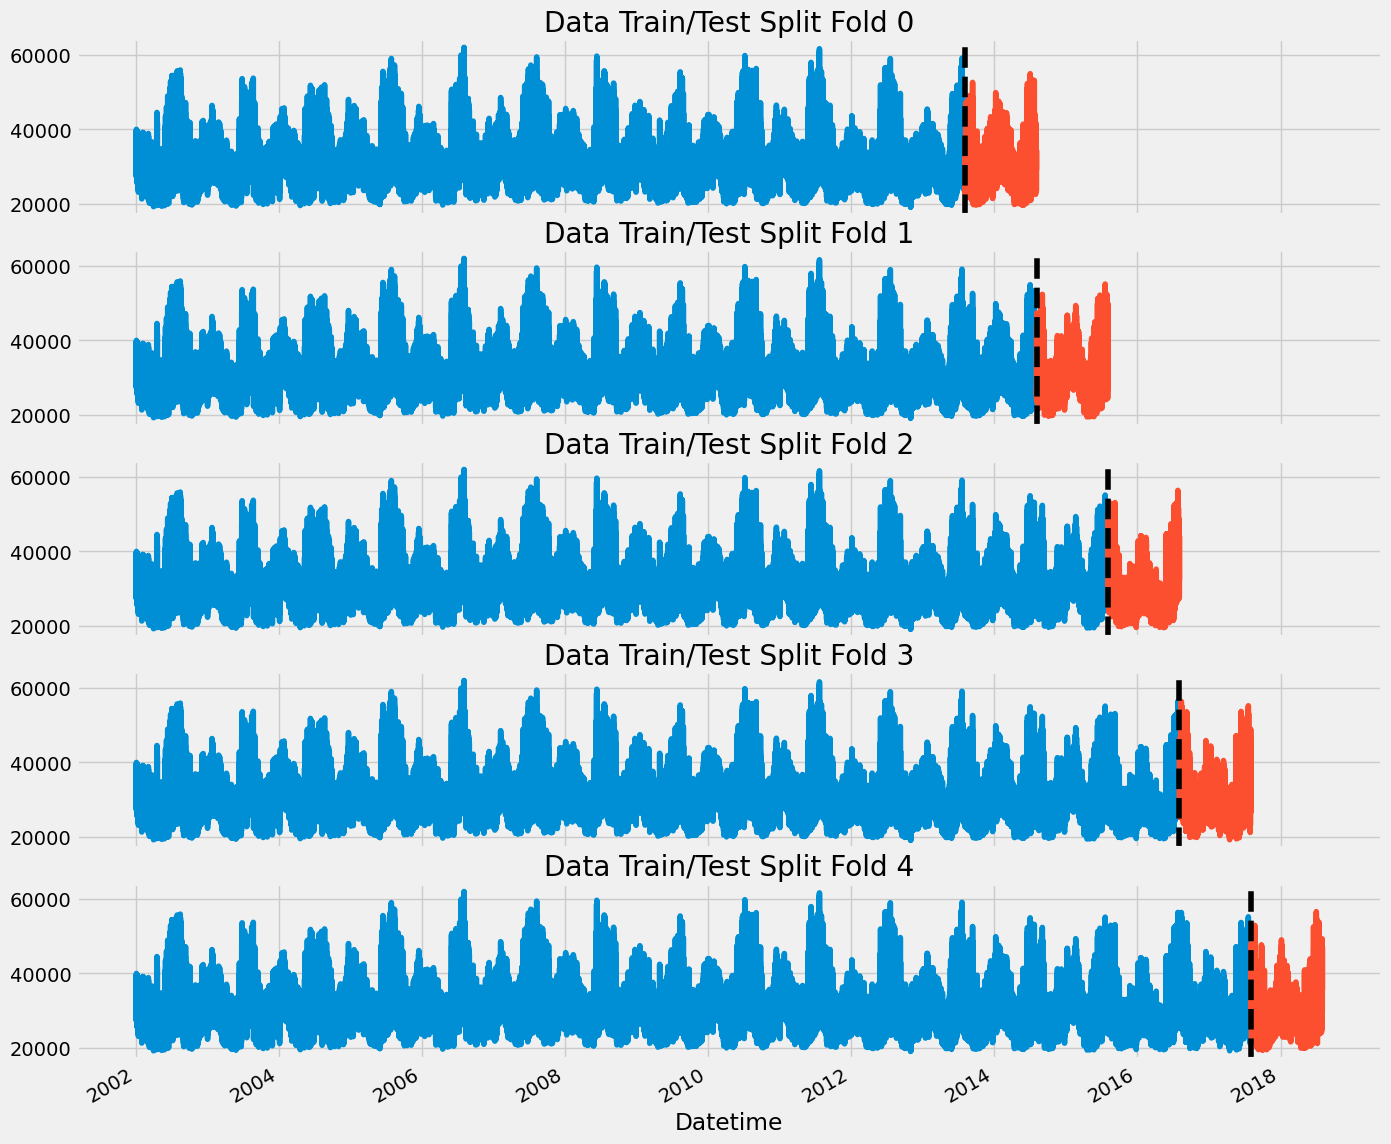

In [16]:
import xgboost as xgb
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)


from sklearn.metrics import mean_squared_error
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1

    FEATURES = ['hour','dayofweek','quarter','month','year','dayofmonth','weekofyear',
                'lag1','lag2','lag3','lag4','holiday']
    TARGET = 'PJME_MW'
    X_train = train[FEATURES]
    y_train = train[TARGET]
    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=10000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=5,
                           learning_rate=0.1,max_leaves=3)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=0)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

In [17]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3729.1253
Fold scores:[3744.5793859326022, 3338.8388253694243, 3588.1391975611496, 4065.3861583152266, 3908.682860398135]


In [18]:
test['MW_Prediction'] = reg.predict(X_test)

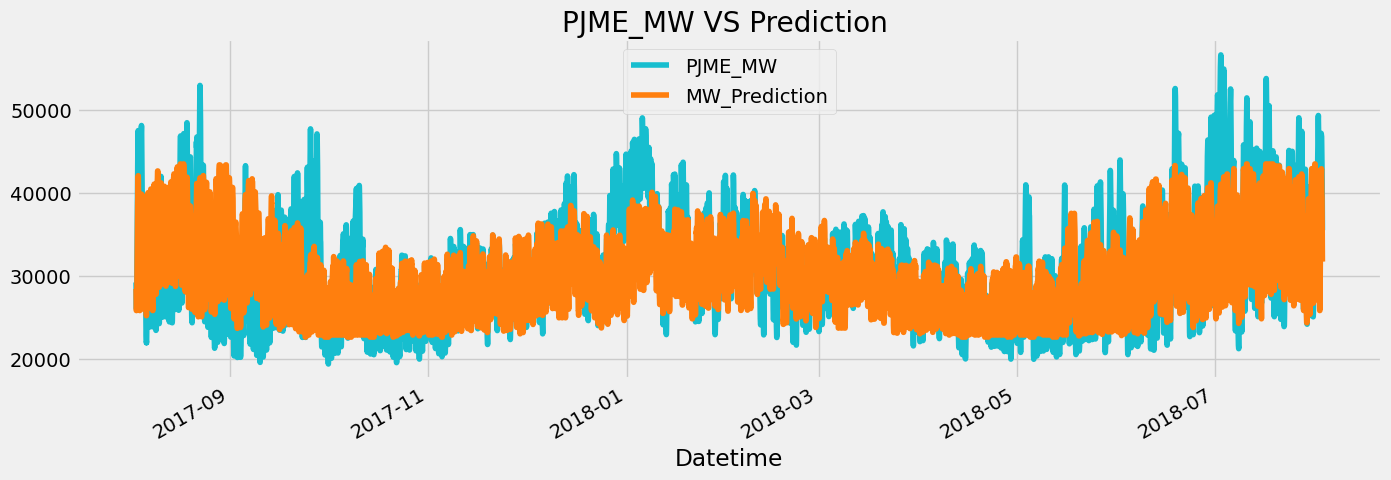

In [19]:
fig, ax = plt.subplots(figsize=(15, 5))
test['PJME_MW'].plot(ax=ax,
                          label='PJME_MW',
                          title=f'PJME_MW VS Prediction ',color=color_pal[9])
test['MW_Prediction'].plot(ax=ax,
                         label='MW_Prediction',color=color_pal[1])
ax.legend(['PJME_MW', 'MW_Prediction'])
plt.show()

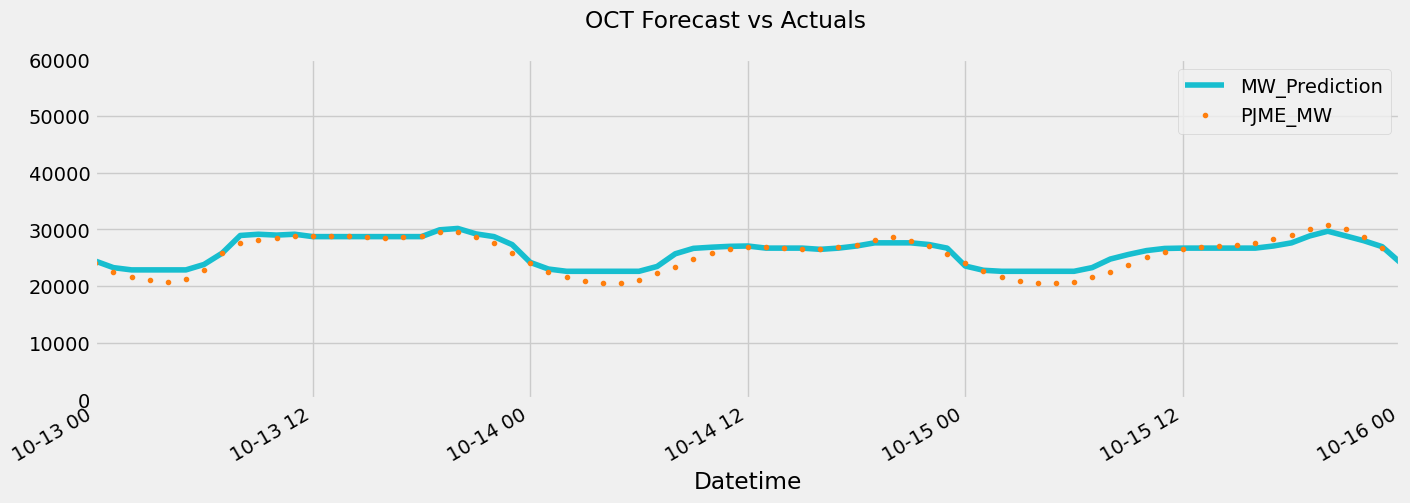

In [20]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = test[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'],color=[color_pal[9],color_pal[1]])
ax.set_xbound(lower='10-13-2017', upper='10-16-2017')
ax.set_ylim(0, 60000)
plot = plt.suptitle('OCT Forecast vs Actuals')

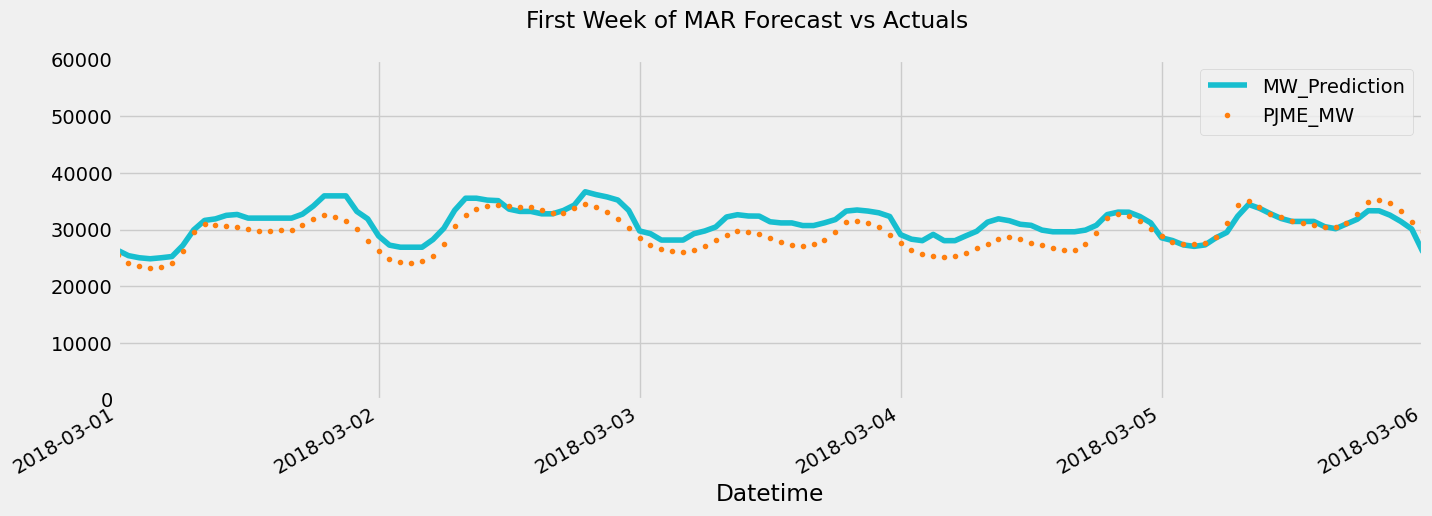

In [21]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = test[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'],color=[color_pal[9],color_pal[1]])
ax.set_xbound(lower='03-01-2018', upper='03-06-2018')
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of MAR Forecast vs Actuals')

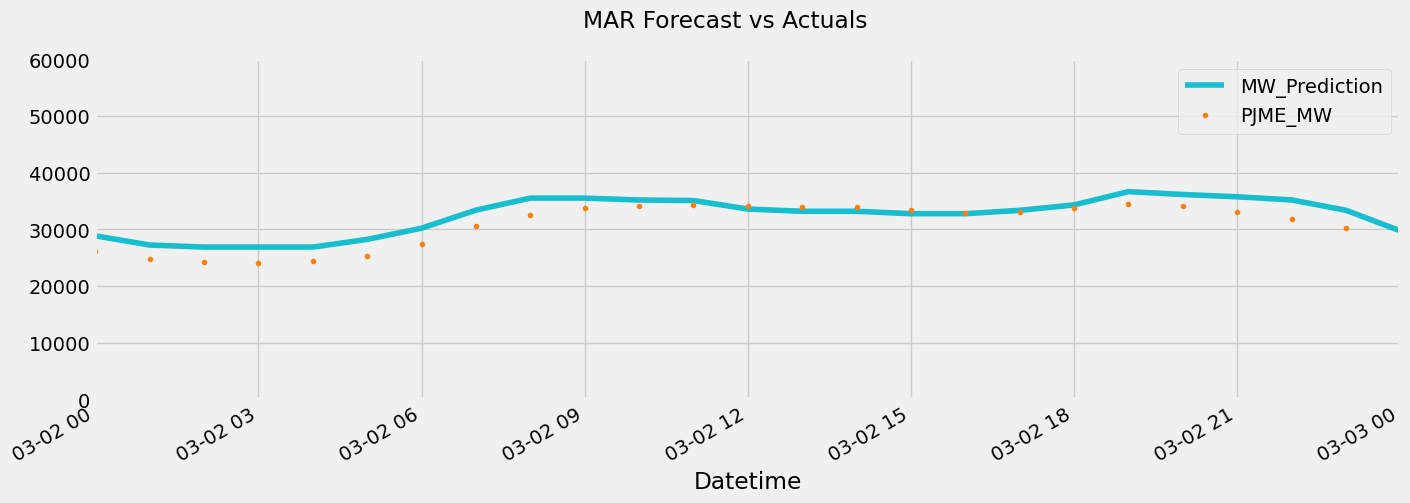

In [22]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = test[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'],color=[color_pal[9],color_pal[1]])
ax.set_xbound(lower='03-02-2018', upper='03-03-2018')
ax.set_ylim(0, 60000)
plot = plt.suptitle('MAR Forecast vs Actuals')

In [23]:
# Create future dataframe
future = pd.date_range('2018-08-03','2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [24]:
future_w_features = df_and_future.query('isFuture').copy()

In [25]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

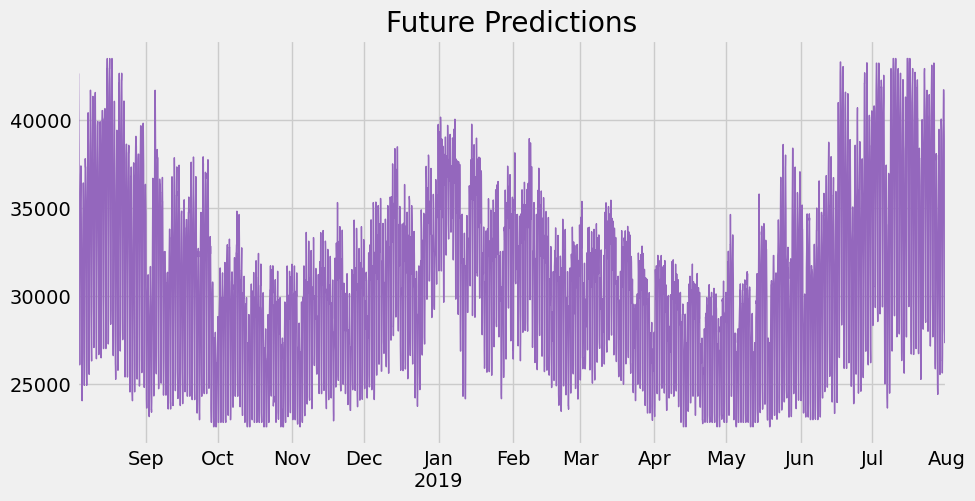

In [26]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

In [27]:
# Save model
reg.save_model('model.json')